In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

/Users/juliankleindiek/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def plot_inertia(array, start=1, end=10):
    '''
    Function to find ideal number of clusters, plotting the elbow method.
    '''
    
    # claculate interias
    inertia = []
    ks = range(start, end+1)
    
    for k in ks:
        model = KMeans(n_clusters = k, random_state = 0).fit(array)
        inertia.append(model.inertia_)
    
    # plot interias
    fig, ax = plt.subplots(figsize=(10,6))
    plt.plot(ks, inertia, '-o')
    ax.set_title('The elbow method')
    ax.set_ylabel('Inertia')
    ax.set_xlabel('Number of clusters')
    plt.show()
    
    # return plot
    return ax

def plot_pair(reduced, clusters): 
    '''
    Function to visualize the data distribution of the first four principal components of pca-reduced data. Diagonal plots are histograms. The off-diagonal plots 
    are scatter plots vizualizing the clsuters.
    '''
    
    df = pd.DataFrame(reduced)
    df['c'] = clusters
    subset = [0,1,2,3, 'c']
    columns = [0,1,2,3]
    ax = sns.PairGrid(df[subset], vars = columns, hue = 'c')
    ax = ax.map_diag(plt.hist)
    ax = ax.map_offdiag(plt.scatter)
    return ax

## Data Import

In [3]:
dat = pd.read_csv("01_Data/spotify_dat_undummy.csv", index_col = 0)

In [4]:
# select track info and audio features
dat_audio = dat[['name', 'album_name', 'artist_name', 'genre_agg', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 
                 'valence', 'tempo', 'num_of_sections', 'num_of_keys', 'num_of_modes', 'num_of_time_signatures', 'duration_minutes', 'section_durations_variance', 
                 'section_durations_min', 'section_durations_max', 'section_loudnesses_variance', 'section_loudnesses_min', 'section_durations_max', 'section_tempos_variance', 
                 'section_tempos_min', 'section_tempos_max']]

In [5]:
# data characteristics
dat_audio.describe()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,num_of_sections,...,duration_minutes,section_durations_variance,section_durations_min,section_durations_max,section_loudnesses_variance,section_loudnesses_min,section_durations_max,section_tempos_variance,section_tempos_min,section_tempos_max
count,21445.000000,21445.000000,21445.000000,21445.000000,21445.000000,21445.000000,21445.000000,21445.000000,21445.000000,21445.000000,...,21445.000000,21445.000000,21445.000000,21445.00000,21445.000000,21445.000000,21445.00000,21445.000000,21445.000000,21445.000000
mean,0.325030,0.592534,0.570421,0.128831,0.180113,-9.197433,0.105270,0.466093,118.652695,9.921240,...,3.714809,207.362096,8.790962,49.08747,38.116577,-24.084008,49.08747,164.803096,103.800477,122.035042
std,0.339922,0.185395,0.253807,0.298598,0.146917,6.652551,0.118834,0.246981,30.869648,4.020907,...,1.501485,568.544509,4.936823,19.61420,46.719061,11.945207,19.61420,446.738229,47.446615,30.976738
min,0.000000,0.000000,0.000020,0.000000,0.015700,-54.376000,0.000000,0.000000,0.000000,1.000000,...,0.266967,0.000000,0.689220,10.55914,0.000000,-60.000000,10.55914,0.000000,0.000000,0.000000
25%,0.038100,0.472000,0.426000,0.000000,0.095300,-10.068000,0.037300,0.270000,94.614000,8.000000,...,2.989100,73.072618,7.042400,36.20784,7.687671,-31.802000,36.20784,0.077714,83.282000,97.313000
50%,0.181000,0.611000,0.615000,0.000004,0.121000,-6.916000,0.052400,0.456000,118.029000,9.000000,...,3.524000,128.602777,8.288100,45.18608,21.581525,-22.206000,45.18608,0.790837,109.908000,121.095000
75%,0.563000,0.733000,0.762000,0.003520,0.213000,-5.160000,0.118000,0.655000,139.979000,11.000000,...,4.143550,231.688916,10.028160,57.23816,50.850488,-14.578000,57.23816,6.542261,135.512000,142.755000
max,0.996000,0.986000,1.000000,1.000000,0.999000,1.023000,0.966000,0.992000,232.690000,71.000000,...,43.403333,59604.007570,240.000000,494.22259,447.304673,-0.006000,494.22259,6025.408851,218.892000,242.142000


In [6]:
# create arrays
x = dat_audio.iloc[:,4:].values
y = dat_audio.iloc[:,:4]

In [7]:
# standardization of data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
pd.DataFrame(x_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
count,2.144500e+04,2.144500e+04,2.144500e+04,2.144500e+04,2.144500e+04,2.144500e+04,2.144500e+04,2.144500e+04,2.144500e+04,2.144500e+04,...,2.144500e+04,2.144500e+04,2.144500e+04,2.144500e+04,2.144500e+04,2.144500e+04,2.144500e+04,2.144500e+04,2.144500e+04,2.144500e+04
mean,9.767063e-17,-6.484800e-17,3.818815e-16,2.542936e-15,-5.667340e-17,1.973086e-16,7.691058e-17,2.580045e-16,4.249548e-16,-1.461301e-15,...,-4.083441e-16,7.095177e-17,-2.223423e-17,8.241898e-18,-3.975991e-18,-1.531067e-16,8.241898e-18,-5.919723e-17,-3.783508e-16,8.792739e-16
std,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,...,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00
min,-9.562107e-01,-3.196136e+00,-2.247434e+00,-4.314647e-01,-1.119118e+00,-6.791323e+00,-8.858826e-01,-1.887206e+00,-3.843758e+00,-2.218765e+00,...,-2.296342e+00,-3.647330e-01,-1.641122e+00,-1.964354e+00,-8.158868e-01,-3.006798e+00,-1.964354e+00,-3.689117e-01,-2.187783e+00,-3.939662e+00
25%,-8.441236e-01,-6.501605e-01,-5.690329e-01,-4.314647e-01,-5.773008e-01,-1.308652e-01,-5.719910e-01,-7.939789e-01,-7.787344e-01,-4.778239e-01,...,-4.833389e-01,-2.362042e-01,-3.541960e-01,-6.566636e-01,-6.513319e-01,-6.461313e-01,-6.566636e-01,-3.687377e-01,-4.324640e-01,-7.981027e-01
50%,-4.237234e-01,9.960757e-02,1.756452e-01,-4.314517e-01,-4.023675e-01,3.429490e-01,-4.449195e-01,-4.086683e-02,-2.020463e-02,-2.291179e-01,...,-1.270832e-01,-1.385312e-01,-1.018619e-01,-1.989111e-01,-3.539334e-01,1.572222e-01,-1.989111e-01,-3.671414e-01,1.287271e-01,-3.034740e-02
75%,7.000896e-01,7.576774e-01,7.548393e-01,-4.196760e-01,2.238530e-01,6.069140e-01,1.071259e-01,7.648821e-01,6.908664e-01,2.682939e-01,...,2.855514e-01,4.278889e-02,2.506119e-01,4.155602e-01,2.725699e-01,7.958195e-01,4.155602e-01,-3.542668e-01,6.683778e-01,6.689033e-01
max,1.973940e+00,2.122363e+00,1.692582e+00,2.917599e+00,5.573954e+00,1.536354e+00,7.243323e+00,2.129391e+00,3.694242e+00,1.519065e+01,...,2.643347e+01,1.044738e+02,4.683466e+01,2.269506e+01,8.758687e+00,2.015751e+00,2.269506e+01,1.311896e+01,2.425762e+00,3.877418e+00


In [8]:
# take a subset of entire data set only to run algos faster
x_test = x_scaled[:, :]
y_test = y[:]

## Data Clustering
Goal: Apply different clustering techniques to create clusters based on the audio features of the songs to define music genres

#### t-SNE

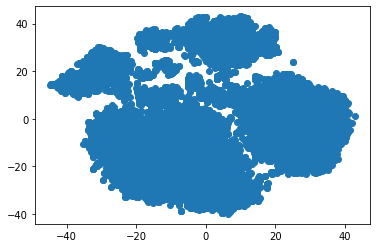

In [1512]:
# initiate the model
tsne = TSNE(learning_rate= 100, perplexity = 100)

# fit the model an transform the data
x_tsne = tsne.fit_transform(x_test)

# plot tsne results
plt.scatter(x_tsne[:,0], x_tsne[:,1])
plt.show()

Looks like there are definitely some clusters. I also expect KMeans to perform better than DBSCAN based on the globular shape of the t-SNE results.

#### DBSCAN

In [24]:
# initiate model
dbscan = DBSCAN(eps = 5, min_samples = 200)

# fit the model
dbscan.fit(x_test)

# get labels
labels_dbscan = dbscan.labels_
print("These are the DBSCAN labels:", Counter(labels_dbscan))

These are the DBSCAN labels: Counter({0: 20974, -1: 471})


We played around with the parameters of DBSCAN, but it only finds one cluster and outliers at maximum. It appears to be not very useful for this dataset.

#### K-Means

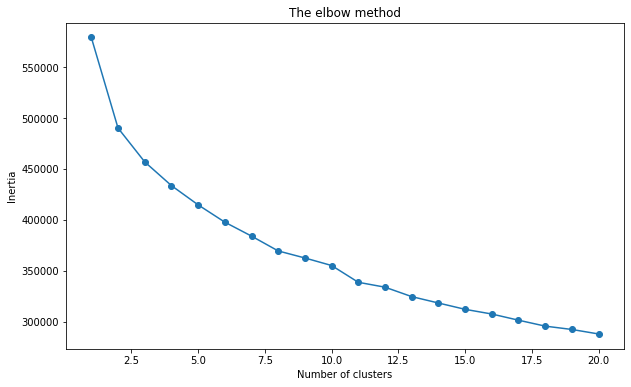

In [27]:
# find ideal number of clusters
inertia = plot_inertia(x_test, 1, 20)

The elbow method shows that 8 clusters are a good fit. This is slightly lower than the 13 genres we have in our dataset.

In [9]:
# set number of clusters
n_cluster = 8

# instantiate kmeans with n_clusters
kmeans = KMeans(n_clusters = n_cluster, random_state = 3)

# fit kmeans to the input data
kmeans = kmeans.fit(x_test)

# create cluster labels
labels_audio_features_kmeans = kmeans.predict(x_test)

In [10]:
# create a dataframe aligning labels and songs
dat_audio_kmeans = pd.concat([pd.DataFrame(labels_audio_features_kmeans, columns = ["labels_audio_features_kmeans"]), y_test], axis = 1)

# find number of song in each cluster
dat_audio_kmeans[["labels_audio_features_kmeans", "name"]].groupby("labels_audio_features_kmeans").count().reset_index()

,labels_audio_features_kmeans,name
0,0,2204
1,1,2186
2,2,1996
3,3,5446
4,4,772
5,5,2038
6,6,14
7,7,6789


In [11]:
# explore clusters
dat_audio_kmeans[dat_audio_kmeans["artist_name"]== "Justin Bieber"].sort_values("labels_audio_features_kmeans")

,labels_audio_features_kmeans,name,album_name,artist_name,genre_agg
6343,1,That's What Love Is,Changes,Justin Bieber,pop
8794,1,One Less Lonely Girl,My World,Justin Bieber,pop
20580,2,Right Here,Believe (Deluxe Edition),Justin Bieber,pop
20532,2,Hold Tight,Journals,Justin Bieber,pop
1416,2,At Least For Now,Changes,Justin Bieber,pop
1438,2,Forever (feat. Post Malone & Clever),Changes,Justin Bieber,pop
20436,2,Heartbreaker,Journals,Justin Bieber,pop
8374,2,Confident,Journals,Justin Bieber,pop
6339,2,E.T.A.,Changes,Justin Bieber,pop
8968,2,Somebody To Love,My World 2.0,Justin Bieber,pop


The artist "Justin Bieber" is represented in 5 clusters although his music is assigned to one genre only. This allows two interpretations:
1. Although being assigned to one genre only, the audio features of the individual songs are still substantially different, meaning that the assigned genre is inaccurate
2. K-Means is not an appropriate method to cluster music into genres based on audio features

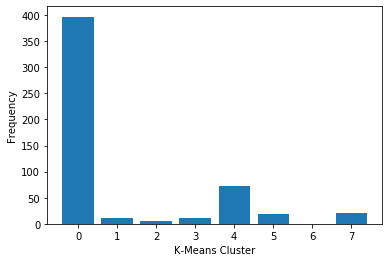

In [61]:
# further explore clusters
bach = dat_audio_kmeans[dat_audio_kmeans["artist_name"] == "Johann Sebastian Bach"][["labels_audio_features_kmeans", "name"]].groupby("labels_audio_features_kmeans").count().reset_index()

# plot results
plot = plt.bar(bach["labels_audio_features_kmeans"].unique(), bach["name"])
plt.xlabel('K-Means Cluster')
plt.ylabel('Frequency')
plt.show()

This representation shows the distribution of music written by "Johann Sebastian Bach", a famous component of classical music. We can observe a clear tendency of his music towards cluster 0, which appears to be capturing classical music. However, there are several songs in clsuter 4.

In [13]:
# create a DataFrame with clusters and genres
df_kmeans = pd.DataFrame({'clusters': labels_audio_features_kmeans, 'genres': dat_audio_kmeans["genre_agg"].values})

# create cross table
ct_kmeans = pd.crosstab(df_kmeans['clusters'], df_kmeans['genres'])
ct_kmeans

genres,alternative metal/rock,background,baroque classic,classical,country,hip hop,house,indie,mexican,misc,pop,rap,rock
clusters,,,,,,,,,,,,,
0,5,219,427,639,7,11,4,60,0,775,32,4,21
1,56,0,11,32,335,220,87,151,84,584,271,107,248
2,121,1,6,2,117,340,47,170,9,543,240,153,247
3,290,0,12,4,321,1042,157,277,101,1494,644,570,534
4,14,3,77,540,0,4,1,2,0,109,7,1,14
5,46,0,21,6,159,251,123,141,43,606,386,104,152
6,0,0,0,0,0,0,0,0,0,14,0,0,0
7,215,0,21,4,319,1111,301,430,171,1905,1154,574,584


In [14]:
# represented in % of row
ct_percent_kmeans = pd.DataFrame((np.asarray(ct_kmeans).T/np.asarray(ct_kmeans).sum(axis=1)).T)
ct_percent_kmeans.rename(columns = {v: k for v, k in enumerate(list(ct_kmeans.columns))}, inplace = True)
ct_percent_kmeans.round(2)*100

,alternative metal/rock,background,baroque classic,classical,country,hip hop,house,indie,mexican,misc,pop,rap,rock
0,0.0,10.0,19.0,29.0,0.0,0.0,0.0,3.0,0.0,35.0,1.0,0.0,1.0
1,3.0,0.0,1.0,1.0,15.0,10.0,4.0,7.0,4.0,27.0,12.0,5.0,11.0
2,6.0,0.0,0.0,0.0,6.0,17.0,2.0,9.0,0.0,27.0,12.0,8.0,12.0
3,5.0,0.0,0.0,0.0,6.0,19.0,3.0,5.0,2.0,27.0,12.0,10.0,10.0
4,2.0,0.0,10.0,70.0,0.0,1.0,0.0,0.0,0.0,14.0,1.0,0.0,2.0
5,2.0,0.0,1.0,0.0,8.0,12.0,6.0,7.0,2.0,30.0,19.0,5.0,7.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
7,3.0,0.0,0.0,0.0,5.0,16.0,4.0,6.0,3.0,28.0,17.0,8.0,9.0


The cross tables support the statement that we can observe some tendencies of the clusters towards the genres but clearly no clear-cut clusters.

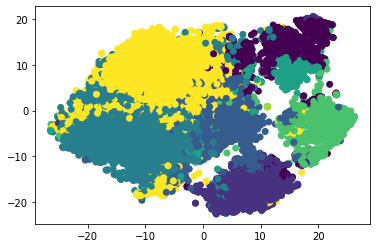

In [15]:
# plot results using t-SNE
tsne = TSNE(learning_rate= 30, perplexity = 300)

# fit the model an transform the data
x_tsne = tsne.fit_transform(x_test)

# plot tsne results
plt.scatter(x_tsne[:,0], x_tsne[:,1], c = labels_audio_features_kmeans)
plt.show()

#### K-Means on PCA-reduced data

In [16]:
# fit pca to unscaled data
pca = PCA().fit(x_test)

# find optimal number of components
np.cumsum(pca.explained_variance_ratio_)

array([0.20604646, 0.33214354, 0.44306369, 0.53512454, 0.61490402,
       0.66711403, 0.71822349, 0.76129627, 0.79961485, 0.83606725,
       0.86793061, 0.89585094, 0.91908993, 0.93989459, 0.95799985,
       0.97476353, 0.98572285, 0.99107454, 0.99416487, 0.99687812,
       0.99899294, 1.        , 1.        ])

In [17]:
# fit pca with 11 components
pca = PCA(n_components = 11).fit(x)

# reduce dimensionality of x
x_reduced = pca.fit_transform(x)

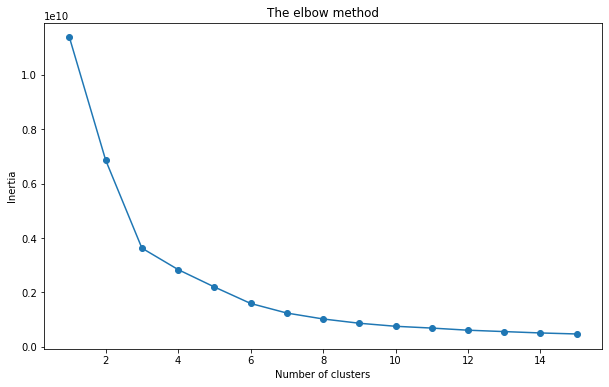

In [18]:
# find ideal number of clusters
inertia = plot_inertia(x_reduced, 1, 15)

For the PCA-reduced data, the ideal number of components appears to be 7.

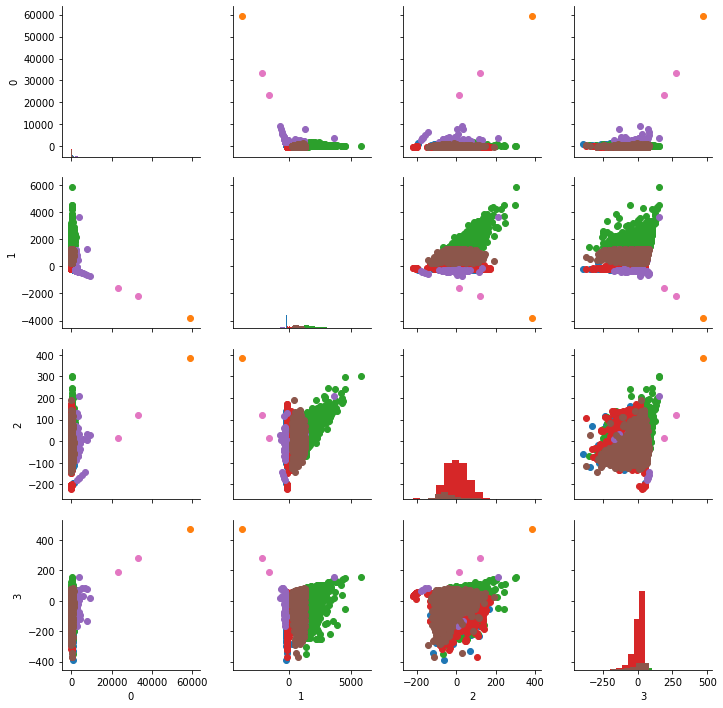

In [19]:
# instantiate kmeans
kmeans = KMeans(n_clusters = 7, random_state = 3)

# fit kmeans
x_reduced_kmeans_labels = kmeans.fit_predict(x_reduced)

# plot the clusters, only considering the first 4 components for plotting purposes
plot = plot_pair(x_reduced, x_reduced_kmeans_labels)

In [20]:
# create a dataframe aligning labels and songs
dat_audio_kmeans_pca = pd.concat([pd.DataFrame(x_reduced_kmeans_labels, 
                                               columns = ["x_reduced_kmeans_labels"]), 
                                  y_test], axis = 1)

In [21]:
# find number of song in each cluster
dat_audio_kmeans_pca[["x_reduced_kmeans_labels", "name"]].groupby("x_reduced_kmeans_labels").count().reset_index()

,x_reduced_kmeans_labels,name
0,0,1585
1,1,1
2,2,652
3,3,16951
4,4,83
5,5,2171
6,6,2


As far as for running K-Means on pca-reduced data, we observe that there is no balanced assignment of songs into the different clusteres. We can observe that approx. 3/4 of our data is clustered into one cluster only. The results of clustering songs without performing pca on the data are superior to the results of reducing dimensionality before applying K-Means.

#### Agglomerative Clustering

In [33]:
# initialize for n_clusters = number of genres (13)
agglom = AgglomerativeClustering(n_clusters = 13)

# fit model
agglom.fit(x_test)

# extract labels
labels_audio_features_agglom = agglom.labels_

In [34]:
# create a dataframe aligning labels and songs
dat_audio_agglom = pd.concat([pd.DataFrame(labels_audio_features_agglom, 
                                           columns = ["labels_audio_features_agglom"]), 
                              y_test], axis = 1)

In [35]:
# find number of song in each cluster
dat_audio_agglom[["labels_audio_features_agglom", "name"]].groupby("labels_audio_features_agglom").count().reset_index()

,labels_audio_features_agglom,name
0,0,2203
1,1,1923
2,2,7635
3,3,2174
4,4,1415
5,5,1159
6,6,215
7,7,12
8,8,1061
9,9,2149


In [36]:
# create a dataframe with clusters and genres
df_agglom = pd.DataFrame({'clusters': labels_audio_features_agglom, 'genres': dat_audio_agglom["genre_agg"].values})

# create cross table
ct_agglom = pd.crosstab(df_agglom['clusters'], df_agglom['genres'])
ct_agglom

genres,alternative metal/rock,background,baroque classic,classical,country,hip hop,house,indie,mexican,misc,pop,rap,rock
clusters,,,,,,,,,,,,,
0,50,9,44,44,169,246,116,157,43,664,397,101,163
1,98,0,3,0,128,279,38,154,21,556,285,123,238
2,290,0,9,1,378,1308,400,448,222,1992,1215,712,660
3,197,0,2,8,191,145,58,135,23,673,273,129,340
4,9,0,0,1,4,648,19,21,4,338,90,273,8
5,1,112,250,302,1,5,4,19,0,450,3,5,7
6,1,0,8,173,0,0,0,1,0,31,0,0,1
7,0,0,0,0,0,0,0,0,0,12,0,0,0
8,0,102,148,586,0,1,2,16,0,201,0,1,4


In [37]:
# represented in % of row
ct_percent_agglom = pd.DataFrame((np.asarray(ct_agglom).T/np.asarray(ct_agglom).sum(axis=1)).T)
ct_percent_agglom.rename(columns = {v: k for v, k in enumerate(list(ct_agglom.columns))}, inplace = True)
ct_percent_agglom.round(2)*100

,alternative metal/rock,background,baroque classic,classical,country,hip hop,house,indie,mexican,misc,pop,rap,rock
0,2.0,0.0,2.0,2.0,8.0,11.0,5.0,7.0,2.0,30.0,18.0,5.0,7.0
1,5.0,0.0,0.0,0.0,7.0,15.0,2.0,8.0,1.0,29.0,15.0,6.0,12.0
2,4.0,0.0,0.0,0.0,5.0,17.0,5.0,6.0,3.0,26.0,16.0,9.0,9.0
3,9.0,0.0,0.0,0.0,9.0,7.0,3.0,6.0,1.0,31.0,13.0,6.0,16.0
4,1.0,0.0,0.0,0.0,0.0,46.0,1.0,1.0,0.0,24.0,6.0,19.0,1.0
5,0.0,10.0,22.0,26.0,0.0,0.0,0.0,2.0,0.0,39.0,0.0,0.0,1.0
6,0.0,0.0,4.0,80.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
8,0.0,10.0,14.0,55.0,0.0,0.0,0.0,2.0,0.0,19.0,0.0,0.0,0.0
9,3.0,0.0,1.0,2.0,16.0,10.0,3.0,7.0,4.0,26.0,12.0,5.0,11.0


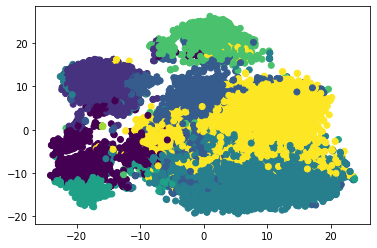

In [38]:
# plot results using t-SNE
tsne = TSNE(learning_rate= 30, perplexity = 300)

# fit the model an transform the data
x_tsne = tsne.fit_transform(x_test)

# plot tsne results
plt.scatter(x_tsne[:,0], x_tsne[:,1], c = labels_audio_features_kmeans)
plt.show()

Agglomerative Clustering does not produce superior results to K-Means.

## Conclusion
Overall, we conclude that there certainly are no clear-cut lines when it comes to clustering music into genres based on audio features. The boundaries of music are fluid, making it an impossible task to cluster music into representative clusters. This conclusion is supported by the fact that Spotify assigns a given song to several very granular sub-genres (approx. 4 on average). This allows Spotify to capture the slight variations in music and accounts for the flexible boundaries in-between music genres.
Conclusively, we can say that clustering music into 13 clusters isn't the best approach to clustering music into genres.